<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter09/predicting_multiple_instances_of_multiple_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar
!pip install -qU torch_snippets
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 36.7MB 77kB/s 
     |████████████████████████████████| 102kB 14.6MB/s 


In [ ]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

2020-11-07 13:58:04.425 | INFO     | torch_snippets.loader:Glob:181 - 20210 files found at images/training
2020-11-07 13:58:04.469 | INFO     | torch_snippets.loader:Glob:181 - 20210 files found at annotations_instance/training


In [ ]:
classes_list = [4,6]
annots = []
for ann in Tqdm(all_annots):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if np.array([num in np.unique(r) for num in classes_list]).sum()==0: continue
    annots.append(ann)
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

100%|██████████| 20210/20210 [03:10<00:00, 106.29it/s]


In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
def get_mask(path):
    an = read(path, 1).transpose(2,0,1)
    r,g,b = an
    cls = list(set(np.unique(r)).intersection({4,6}))
    print(cls)
    masks = []
    labels = []
    for _cls in cls:
      nzs = np.nonzero(r==_cls)
      instances = np.unique(g[nzs])
      for ix,_id in enumerate(instances):
          masks.append(g==_id)
          labels.append(classes_list.index(_cls)+1)
    return np.array(masks), np.array(labels)

In [ ]:
_id = trn_items[10]
img_path = f'images/training/{_id}.jpg'

In [ ]:
get_mask(img_path)

[4, 6]


(array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, 

2020-11-07 14:01:15.692 | INFO     | torch_snippets.loader:subplots:375 - plotting 8 images in a grid of 2x5 @ (5, 5)


Tensor	Shape: torch.Size([3, 512, 683])	Min: 0.000	Max: 1.000	Mean: 0.504	dtype: torch.float32
Dict Of 6 items
	BOXES:
	Tensor	Shape: torch.Size([7, 4])	Min: 1.000	Max: 475.000	Mean: 278.214	dtype: torch.float32
	LABELS:
	Tensor	Shape: torch.Size([7])	Min: 1.000	Max: 1.000	Mean: 1.000	dtype: torch.int64
	MASKS:
	Tensor	Shape: torch.Size([7, 512, 683])	Min: 0.000	Max: 1.000	Mean: 0.009	dtype: torch.uint8
	IMAGE_ID:
	Tensor	Shape: torch.Size([1])	Min: 1.000	Max: 1.000	Mean: 1.000	dtype: torch.int64
	AREA:
	Tensor	Shape: torch.Size([7])	Min: 432.000	Max: 10366.000	Mean: 6474.571	dtype: torch.float32
... ... 1 more items


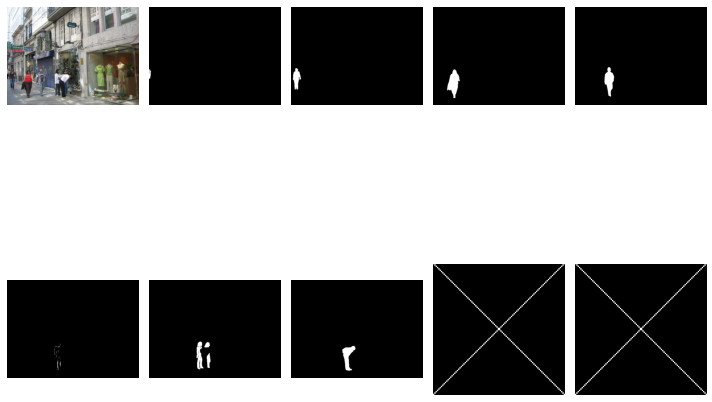

In [ ]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self,path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        cls = list(set(np.unique(r)).intersection({4,6}))
        masks = []
        labels = []
        for _cls in cls:
          nzs = np.nonzero(r==_cls)
          instances = np.unique(g[nzs])
          for ix,_id in enumerate(instances):
              masks.append(g==_id)
              labels.append(classes_list.index(_cls)+1)
        return np.array(masks), np.array(labels)
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks, labels = self.get_mask(mask_path)
        #print(labels)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8):
          img = img/255.
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[1]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [ ]:
model = get_model_instance_segmentation(3).to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=3000)
dataset_test = MasksDataset(val_items, get_transform(train=False), N=800)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [ ]:
num_classes = 3
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [ ]:
model.eval()
pred = model(dataset[0][0][None].to(device))
inspect(pred[0])

Dict Of 4 items
	BOXES:
	Tensor	Shape: torch.Size([100, 4])	Min: 0.000	Max: 382.000	Mean: 177.219	dtype: torch.float32
	LABELS:
	Tensor	Shape: torch.Size([100])	Min: 1.000	Max: 2.000	Mean: 1.120	dtype: torch.int64
	SCORES:
	Tensor	Shape: torch.Size([100])	Min: 0.355	Max: 0.712	Mean: 0.409	dtype: torch.float32
	MASKS:
	Tensor	Shape: torch.Size([100, 1, 340, 382])	Min: 0.000	Max: 1.000	Mean: 0.054	dtype: torch.float32


In [ ]:
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [   0/1500]  eta: 0:16:16  lr: 0.000010  loss: 2.2653 (2.2653)  loss_classifier: 0.9195 (0.9195)  loss_box_reg: 0.1731 (0.1731)  loss_mask: 1.1160 (1.1160)  loss_objectness: 0.0399 (0.0399)  loss_rpn_box_reg: 0.0168 (0.0168)  time: 0.6513  data: 0.0119  max mem: 2875
Epoch: [0]  [  10/1500]  eta: 0:16:16  lr: 0.000060  loss: 2.5998 (2.6990)  loss_classifier: 0.9031 (0.8928)  loss_box_reg: 0.1800 (0.2189)  loss_mask: 1.3047 (1.4537)  loss_objectness: 0.0399 (0.0971)  loss_rpn_box_reg: 0.0132 (0.0365)  time: 0.6557  data: 0.0690  max mem: 4126
Epoch: [0]  [  20/1500]  eta: 0:16:07  lr: 0.000110  loss: 2.3038 (2.2296)  loss_classifier: 0.8112 (0.7332)  loss_box_reg: 0.1800 (0.2395)  loss_mask: 1.0804 (1.1661)  loss_objectness: 0.0265 (0.0665)  loss_rpn_box_reg: 0.0102 (0.0243)  time: 0.6540  data: 0.0871  max mem: 4126
Epoch: [0]  [  30/1500]  eta: 0:15:57  lr: 0.000160  loss: 1.4503 (1.9446)  loss_classifier: 0.3333 (0.5951)  loss_box_reg: 0.1977 (0.2451)  loss_mask: 0.6966 (

KeyboardInterrupt: ignored

[<matplotlib.lines.Line2D>]

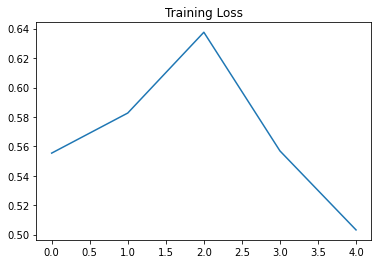

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

In [ ]:
k=408

In [ ]:
k

409

In [ ]:
k=423

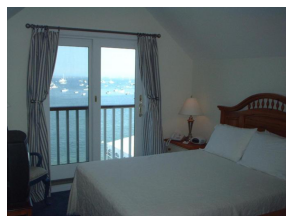

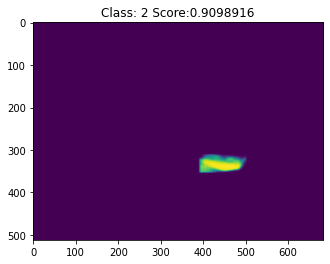

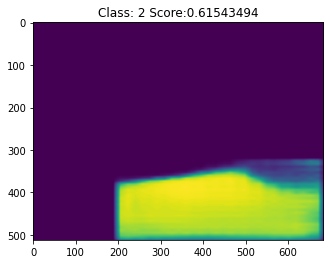

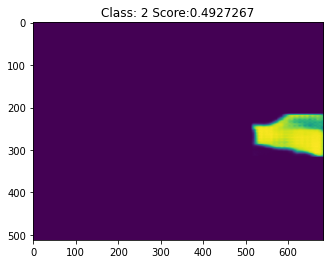

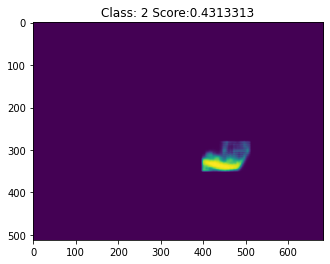

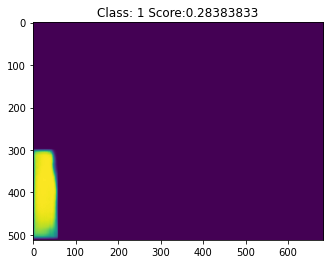

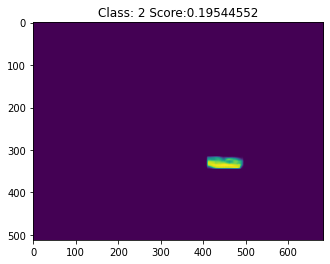

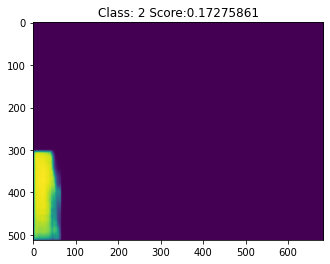

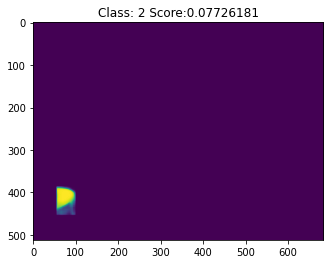

In [ ]:
model.eval()
k+=1
im = dataset_test[k][0]
show(im,sz=5)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()